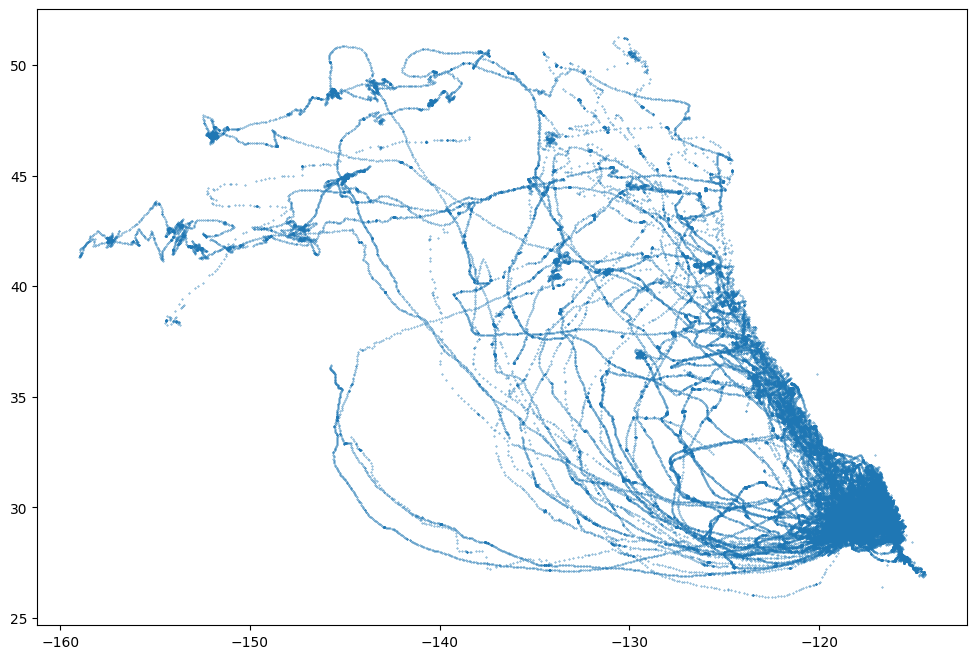

In [1]:
import pandas as pd

df = pd.read_csv('../data/trajectories.csv')

trayectories_df = pd.DataFrame(df)

# Delecciona disinct dates
dates = trayectories_df['date'].unique()

dates_df = pd.DataFrame(dates, columns=['date'])

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(trayectories_df['longitude'], trayectories_df['latitude'], s=0.1)


In [ ]:

# Selecciona netCDF de acuerdo a las fechas del dataframe
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

def select_netCDf(date):
    path = '../data/sst/'
    # Cambia formato de yyyy-mm-dd a yyyymmdd
    date = date.replace('-', '')
    filename = f"{path}/{date}090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_clipped.nc"
    # If filename exists the open it and get lat, lon and SST, else SST = 'NA'
    nc_file = nc.Dataset(filename)
    print(nc_file.variables.keys())
    # Get lat and lon
    lat = nc_file.variables['lat'][:]
    lon = nc_file.variables['lon'][:]
    # Get SST
    sst = nc_file.variables['analysed_sst'][0][:,:]
    sst = sst - 273.15
    # Close netCDF
    nc_file.close()
    return lon, lat, sst


In [ ]:
def plot_netCDF(date):
    lon, lat, sst = select_netCDf(date)
    # Plot netCDF
    #plt.pcolor(lon, lat, sst)
    #plt.title(f"Sea Surface Temperature {date}")

fecha = dates_df['date'][3]
plot_netCDF(fecha)

In [ ]:
import matplotlib.pyplot as plt

# Grafica puntos de una fecha en particular
def get_points(date):
    points = trayectories_df[trayectories_df['date'] == date]
    return points

In [ ]:
import numpy as np
# Obten temperaturas de netCDF a partir de coordenadas de puntos

lon, lat, sst = select_netCDf(fecha)

# Plot netCDF
plt.figure(figsize=(12,8))
plt.pcolor(lon, lat, sst, cmap='jet')
plt.colorbar()
plt.clim(0, 30)
plt.scatter(trayectories_df['longitude'], trayectories_df['latitude'], s=0.1, c='DarkBlue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Sea Surface Temperature {fecha}")
plt.show()


In [ ]:
# Obtener temperatura de netCDF a partir de coordenadas de puntos
def get_sst(longitude, latitude, sst, puntos):
    id = []
    sst_points = []
    for i in range(len(puntos)):
        # Obten coordenadas de punto
        lon_point = puntos['longitude'].iloc[i]
        lat_point = puntos['latitude'].iloc[i]
        # Obten indice de coordenadas en netCDF
        lon_index = (abs(longitude - lon_point)).argmin()
        lat_index = (abs(latitude - lat_point)).argmin()
        # Obten temperatura de netCDF
        sst_point = sst[lat_index,lon_index]
        sst_points.append(sst_point)
    puntos['sst'] = sst_points
    return puntos

sst_onsite = get_sst(lon, lat, sst, puntos)
sst_onsite


In [ ]:
# obten SST para todas las fechas

sst_all = pd.DataFrame()

for i in range(len(dates_df)):
    fecha = dates_df['date'].iloc[i]
    lon, lat, sst = select_netCDf(fecha)
    puntos = pd.DataFrame(get_points(fecha))
    sst_onsite = get_sst(lon, lat, sst, puntos)
    sst_all = sst_all._append(sst_onsite)
    print(fecha)

In [ ]:
#sst_all.to_csv('../data/sst_all.csv', index=False)
sst_all[sst_all['sst'] == -9999] = np.nan

# convertir columna ssst a float con 3 decimales
sst_all['sst'] = sst_all['sst'].astype(float).round(3)
sst_all.describe()

# cuenta de valores nulos
sst_all.isnull().sum()

# Escritura de archivo csv
sst_all.to_csv('../data/sst_all.csv', index=False)
